# Content-Based Image Retrieval System
### Boyuan Cheng (s5526309)

## 1. Introduction
This project develops an image search system through a content-based image retrieval approach. This method usually focuses on global and local information, so this project extracts image color-based feature representation (HSV histogram), shape-based feature representation (Histogram of Oriented Gradient), texture-based feature representation (Gabor filter) three categories features, and apply them to the well-known CIFAR-10 dataset for experiments. In this project, I use both clustering and classification methods to explore which feature or combination of features and which data mining algorithm performs best for image retrieval tasks.

## 2. Dataset
The CIFAR-10 dataset is a well-known image classification dataset that consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 testing images, with each class containing an equal number of images. The 10 classes in the dataset are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The images in the dataset are relatively low-resolution and simple, which makes it an ideal dataset for image classification algorithms. However, considering the frequency of experiments and the limitation of computing equipment, I only use 10,000 pictures as the training set in this project.

## 3. Data Pre-processing
### 3.1 Data Importing
First I import the provided csv files of the three features for training data. In order to facilitate subsequent sorting and searching, I import them into the DataFrame format of pandas. But table headers for them need to be created separately, otherwise the first data will be defaulted as the table header, resulting in missing data.

In [1]:
import pandas as pd
import numpy as np
import csv

In [2]:
gabor_names = ["Name"]  #Gabor features title
for i in range(1,257):
    gabor_names.append("Feature "+str(i))
    
hog_names = ["Name"]  #HOG features title
for i in range(1,361):
    hog_names.append("Feature "+str(i))
    
hsv_names = ["Name"]  #HSV features title
for i in range(1,1441):
    hsv_names.append("Feature "+str(i))

In [3]:
img_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [4]:
Gabor_df = pd.read_csv("Gabor_features.csv",names=gabor_names)
HOG_df = pd.read_csv("HOG_features.csv",names=hog_names)
HSV_df = pd.read_csv("HSV_features.csv",names=hsv_names)
label_df = pd.read_csv("images_labels.csv",names=["Name","Label"])

### 3.2 Data Sorting
 I find that the order of the features table is out of order, and there is no one-to-one correspondence with the labels table. For this problem, I extract the numbers in each sample file name and sort the features table according to the value of the numbers. After the sorting is completed, I delete the "file name" column to make it a table with only feature data.
#### 3.2.1 HSV Features

In [61]:
hsv_index=[]
for i in range(len(HSV_df)):
    idx = HSV_df["Name"][i].split("g")[1]
    idx = int(idx.split(".")[0])
    hsv_index.append(idx)
hsv_index_df = pd.DataFrame(hsv_index,columns=["Index"])
HSVIndex_df = pd.concat([hsv_index_df,HSV_df],axis=1)
HSV_Feature_df = HSVIndex_df.sort_values(by=["Index"]).reset_index()[hsv_names[1:]].fillna(0)

#### 3.2.2 Gabor Features

In [22]:
gabor_index=[]
for i in range(len(Gabor_df)):
    idx = Gabor_df["Name"][i].split("g")[1]
    idx = int(idx.split(".")[0])
    gabor_index.append(idx)
gabor_index_df = pd.DataFrame(gabor_index,columns=["Index"])
GaborIndex_df = pd.concat([gabor_index_df,Gabor_df],axis=1)
Gabor_Feature_df = GaborIndex_df.sort_values(by=["Index"]).reset_index()[gabor_names[1:]].fillna(0)

#### 3.2.3 HOG Features

In [24]:
hog_index=[]
for i in range(len(HOG_df)):
    idx = HOG_df["Name"][i].split("g")[1]
    idx = int(idx.split(".")[0])
    hog_index.append(idx)
HOG_index_df = pd.DataFrame(hog_index,columns=["Index"])
HOGIndex_df = pd.concat([HOG_index_df,HOG_df],axis=1)
HOG_Feature_df = HOGIndex_df.sort_values(by=["Index"]).reset_index()[hog_names[1:]].fillna(0)

### 3.3 Normalization
In this step, I perform a feature normalization pre-processing operation on the entire dataset. Data normalization is able to transform the values of features in the dataset to a common scale, which helps to facilitate comparison and analysis. In the project, I use Z-score normalization which standardizes the values of a feature by using each value to subtract the mean of the feature data, and then dividing the result by the standard deviation of the feature as below:
$$x_{norm} = \frac{x - \frac{1}{n} \sum_{i=1}^{n} x_i}{\sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \frac{1}{n} \sum_{i=1}^{n} x_i)^2}}$$

In [64]:
Norm_HSV_Feature_df = pd.DataFrame()
for i in hsv_names[1:]:
    mean = np.average(HSV_Feature_df[i])
    std = np.std(HSV_Feature_df[i]) 
    normlist = (HSV_Feature_df[i]-mean)/std
    Norm_HSV_Feature_df=pd.concat([Norm_HSV_Feature_df,normlist],axis=1).fillna(0)

In [455]:
Norm_Gabor_Feature_df = pd.DataFrame()
for i in gabor_names[1:]:
    mean = np.average(Gabor_Feature_df[i])
    std = np.std(Gabor_Feature_df[i]) 
    normlist = (Gabor_Feature_df[i]-mean)/std
    Norm_Gabor_Feature_df=pd.concat([Norm_Gabor_Feature_df,normlist],axis=1).fillna(0)

In [457]:
Norm_HOG_Feature_df = pd.DataFrame()
for i in hog_names[1:]:
    mean = np.average(HOG_Feature_df[i])
    std = np.std(HOG_Feature_df[i]) 
    normlist = (HOG_Feature_df[i]-mean)/std
    Norm_HOG_Feature_df=pd.concat([Norm_HOG_Feature_df,normlist],axis=1).fillna(0)

### 3.4 Feature Combination

In [130]:
HSV_Gabor_Feature_df=pd.concat([HSV_Feature_df,Gabor_Feature_df],axis=1)
HSV_HOG_Feature_df=pd.concat([HSV_Feature_df,HOG_Feature_df],axis=1)
Gabor_HOG_Feature_df=pd.concat([Gabor_Feature_df,HOG_Feature_df],axis=1)
HSV_Gabor_HOG_Feature_df=pd.concat([HSV_Feature_df,Gabor_Feature_df,HOG_Feature_df],axis=1)

### 3.5 Test Dataset Pre-processing

In [75]:
Test_Gabor_df = pd.read_csv("Gabor_features4test.csv",names=gabor_names)
Test_HOG_df = pd.read_csv("HOG_features4test.csv",names=hog_names)
Test_HSV_df = pd.read_csv("HSV_features4test.csv",names=hsv_names)
Test_label_df = pd.read_csv("images4test_labels.csv",names=["Name","Label"])

#### 3.5.1 Test HSV Feature

In [78]:
test_hsv_index=[]
for i in range(len(Test_HSV_df)):
    idx = Test_HSV_df["Name"][i].split("4test\image")[1]
    idx = int(idx.split(".")[0])
    test_hsv_index.append(idx)
test_hsv_index_df = pd.DataFrame(test_hsv_index,columns=["Index"])
test_HSVIndex_df = pd.concat([test_hsv_index_df,Test_HSV_df],axis=1)
Test_HSV_Feature_df = test_HSVIndex_df.sort_values(by=["Index"]).reset_index()[hsv_names[1:]].fillna(0)

#### 3.5.2 Test Gabor Feature

In [41]:
test_gabor_index=[]
for i in range(len(Test_Gabor_df)):
    idx = Test_Gabor_df["Name"][i].split("4test\image")[1]
    idx = int(idx.split(".")[0])
    test_gabor_index.append(idx)
test_gabor_index_df = pd.DataFrame(test_gabor_index,columns=["Index"])
test_GaborIndex_df = pd.concat([test_gabor_index_df,Test_Gabor_df],axis=1)
Test_Gabor_Feature_df = test_GaborIndex_df.sort_values(by=["Index"]).reset_index()[gabor_names[1:]].fillna(0)

#### 3.5.3 Test HOG Feature

In [44]:
test_HOG_index=[]
for i in range(len(Test_HOG_df)):
    idx = Test_HOG_df["Name"][i].split("4test\image")[1]
    idx = int(idx.split(".")[0])
    test_HOG_index.append(idx)
test_hog_index_df = pd.DataFrame(test_HOG_index,columns=["Index"])
test_HOGIndex_df = pd.concat([test_hog_index_df,Test_HOG_df],axis=1)
Test_HOG_Feature_df = test_HOGIndex_df.sort_values(by=["Index"]).reset_index()[hog_names[1:]].fillna(0)

#### 3.5.4 Combined Feature

In [354]:
Test_HSV_Gabor_Feature_df=pd.concat([Test_HSV_Feature_df,Test_Gabor_Feature_df],axis=1)
Test_HSV_HOG_Feature_df=pd.concat([Test_HSV_Feature_df,Test_HOG_Feature_df],axis=1)
Test_Gabor_HOG_Feature_df=pd.concat([Test_Gabor_Feature_df,Test_HOG_Feature_df],axis=1)
Test_HSV_Gabor_HOG_Feature_df=pd.concat([Test_HSV_Feature_df,Test_Gabor_Feature_df,Test_HOG_Feature_df],axis=1)

## 4. Clustering Methods
The clustering method is a kind of unsupervised learning, and its measurement standard is the sum of the distances from each sample point to the center of its class, that is, whether it can well separate each unlabeled sample point. Hence we don't need the label of the training set, only the feature data of it. For the compatibility of model parameters, I convert three different features tables into numpy array. 

In [ ]:
HSV_Feature = HSV_Feature_df.to_numpy()
Gabor_Feature = Gabor_Feature_df.to_numpy()
HOG_Feature = HOG_Feature_df.to_numpy()

### 4.1 Clustering (TASK 1)
In this project I choose to use the K-means clustering algorithm. I only use Euclidean distance to compare the similarity between features. Because k-means is designed for Euclidean distance, if we want to use a different distance function, we need to replace the mean with an appropriate center estimation.

In [101]:
from sklearn.cluster import KMeans

In [462]:
kmeans_HSV_clf = KMeans(n_clusters=10)
kmeans_HSV_clf.fit(HSV_Feature)

kmeans_Gabor_clf = KMeans(n_clusters=10)
kmeans_Gabor_clf.fit(Gabor_Feature)

kmeans_HOG_clf = KMeans(n_clusters=10)
kmeans_HOG_clf.fit(HOG_Feature)

KMeans(n_clusters=10)

### 4.2 Image Retreval (TASK 2 + TASK 3 + TASK 4)

In [465]:
from extractimagefeature import ColorDescriptor, GaborDescriptor, HOGDescriptor,chi_squared_distance
import cv2

#### 4.2.1 Clustering based on HSV features

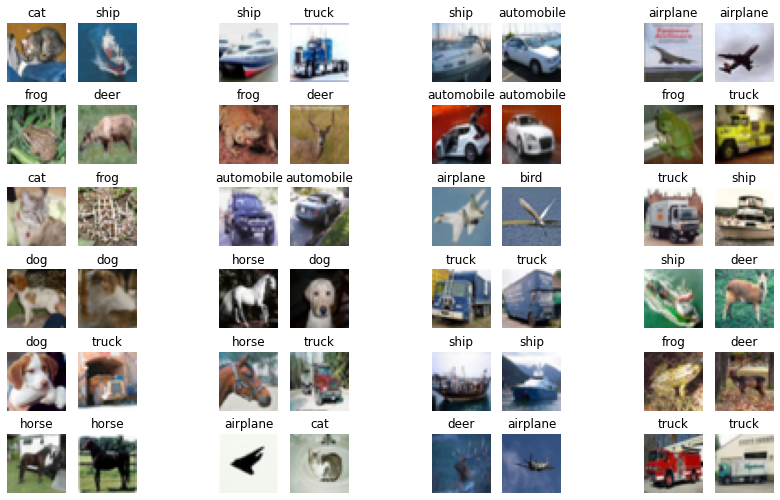

In [555]:
class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.figure(figsize=[15,30])
count=0
for i in range(10000):
    HSV_labels = kmeans_HSV_clf.labels_
    HSV_centers = kmeans_HSV_clf.cluster_centers_
    
    
    #*************** TASK 2 *****************
    test_img = cv2.imread("images_test/image"+str(i+1)+".png")
    bins = (8,12,3)
    cd = ColorDescriptor(bins)
    HSV_features_test = np.array(cd.describe(test_img))
    
    
    #*************** TASK 3 *****************
    distance_list=[]
    for j in range(len(HSV_centers)):
        MSE_distance = np.sum((HSV_centers[j]-HSV_features_test)**2)
        distance_list.append(MSE_distance)
    min_distance = distance_list.index(min(distance_list))
    
    
    #*************** TASK 4 *****************
    samples_index = np.where(HSV_labels == min_distance)[0]
    samples_distance_list=[]
    for j in samples_index:
        samples_MSE_distance = np.sum((HSV_Feature[j]-HSV_features_test)**2)
        samples_distance_list.append(samples_MSE_distance)
    samples_min_distance = samples_distance_list.index(min(samples_distance_list))
    if(test_labels[i]==train_labels[samples_index[samples_min_distance]]):
        count+=1
    print(f"Process: {round((i+1)/100)}%, Accuracy: {round(count/(i+1),4)}",end='\r')
    if(i<24):
        plt.subplot(20,12,3*(i+1)-2)
        plt.axis("off")
        plt.title(class_name[test_labels[i]])
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

        plt.subplot(20,12,3*(i+1)-1)
        plt.axis("off")
        plt.title(class_name[train_labels[samples_index[samples_min_distance]]])
        RetrievalImage = cv2.imread("images/img"+str(samples_index[samples_min_distance]+1)+".png")
        plt.imshow(cv2.cvtColor(RetrievalImage, cv2.COLOR_BGR2RGB))

#### 4.2.2 Clustering based on Gabor features

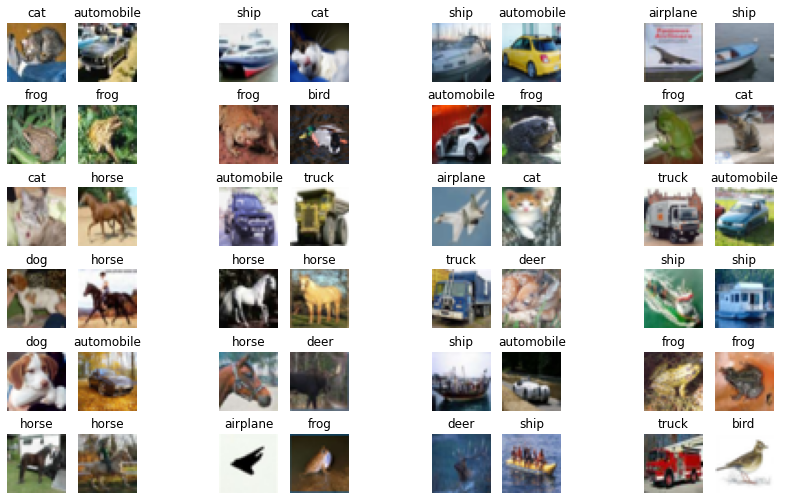

In [488]:
class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.figure(figsize=[15,30])
count=0
for i in range(10000):
    Gabor_labels = kmeans_Gabor_clf.labels_
    Gabor_centers = kmeans_Gabor_clf.cluster_centers_
    
    
    #*************** TASK 2 *****************
    test_img = cv2.imread("images_test/image"+str(i+1)+".png")
    params = {"theta":4, "frequency":(0,1,0.5,0.8), "sigma":(1,3),"n_slice":2}
    gd = GaborDescriptor(params)
    gaborKernels = gd.kernels()
    Gabor_features_test = gd.gaborHistogram(test_img,gaborKernels)
    
    
    #*************** TASK 3 *****************
    distance_list=[]
    for j in range(len(Gabor_centers)):
        MSE_distance = np.sum((Gabor_centers[j]-Gabor_features_test)**2)
        distance_list.append(MSE_distance)
    min_distance = distance_list.index(min(distance_list))
    
    
    #*************** TASK 4 *****************
    samples_index = np.where(Gabor_labels == min_distance)[0]
    samples_distance_list=[]
    for j in samples_index:
        samples_MSE_distance = np.sum((Gabor_Feature[j]-Gabor_features_test)**2)
        samples_distance_list.append(samples_MSE_distance)
    samples_min_distance = samples_distance_list.index(min(samples_distance_list))
    if(test_labels[i]==train_labels[samples_index[samples_min_distance]]):
        count+=1
    print(f"Process: {round((i+1)/100)}%, Accuracy: {round(count/(i+1),4)}",end='\r')
    if(i<24):
        plt.subplot(20,12,3*(i+1)-2)
        plt.axis("off")
        plt.title(class_name[test_labels[i]])
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.subplot(20,12,3*(i+1)-1)
        plt.axis("off")
        plt.title(class_name[train_labels[samples_index[samples_min_distance]]])
        RetrievalImage = cv2.imread("images/img"+str(samples_index[samples_min_distance]+1)+".png")
        plt.imshow(cv2.cvtColor(RetrievalImage, cv2.COLOR_BGR2RGB))

#### 4.2.3 Clustering based on HOG features

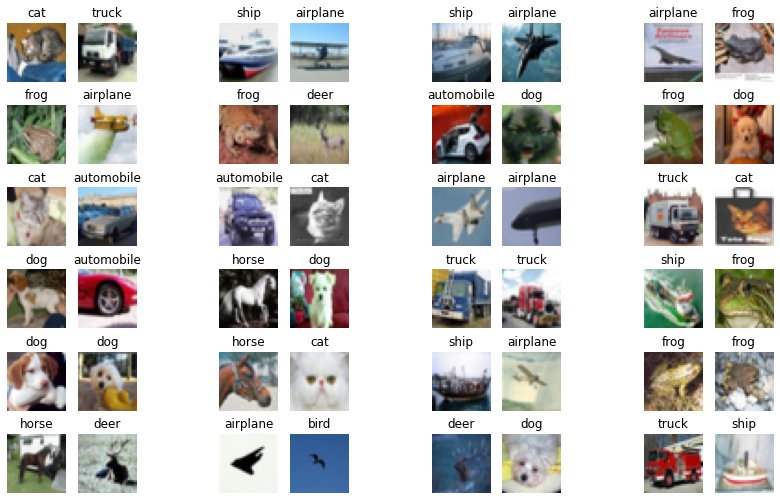

In [557]:
class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.figure(figsize=[15,30])
count=0
for i in range(10000):
    HOG_labels = kmeans_HOG_clf.labels_
    HOG_centers = kmeans_HOG_clf.cluster_centers_
    
    
    #*************** TASK 2 *****************
    test_img = cv2.imread("images_test/image"+str(i+1)+".png")
    hd = HOGDescriptor()
    HOG_features_test = hd.describe(test_img)
    
    
    #*************** TASK 3 *****************
    distance_list=[]
    for j in range(len(HOG_centers)):
        MSE_distance = np.sum((HOG_centers[j]-HOG_features_test)**2)
        distance_list.append(MSE_distance)
    min_distance = distance_list.index(min(distance_list))
    
    
    #*************** TASK 4 *****************
    samples_index = np.where(HOG_labels == min_distance)[0]
    samples_distance_list=[]
    for j in samples_index:
        samples_MSE_distance = np.sum((HOG_Feature[j]-HOG_features_test)**2)
        samples_distance_list.append(samples_MSE_distance)
    samples_min_distance = samples_distance_list.index(min(samples_distance_list))
    if(test_labels[i]==train_labels[samples_index[samples_min_distance]]):
        count+=1
    print(f"Process: {round((i+1)/100)}%, Accuracy: {round(count/(i+1),4)}",end='\r')
    if(i<24):
        plt.subplot(20,12,3*(i+1)-2)
        plt.axis("off")
        plt.title(class_name[test_labels[i]])
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.subplot(20,12,3*(i+1)-1)
        plt.axis("off")
        plt.title(class_name[train_labels[samples_index[samples_min_distance]]])
        RetrievalImage = cv2.imread("images/img"+str(samples_index[samples_min_distance]+1)+".png")
        plt.imshow(cv2.cvtColor(RetrievalImage, cv2.COLOR_BGR2RGB))

### 4.3 Analysis
As can be seen from the results, the clustering algorithm based on HSV features performs the best, followed by the clustering algorithm based on Gabor features, and the worst is the clustering algorithm based on HOG features, even it is close to the accuracy of randomly guessing. However, the accuracy rate of unsupervised learning is generally low. From some of the retrieval results in above, it can be seen that the retrieved images are quite similar to the original image in terms of selected features (color, texture, shape). But due to the diversity of object types and poses, the unsupervised model has misjudged the categories of the original images.

## 5. Classification Methods
Unsupervised learning algorithms do not have access to labeled data, which means that they must learn to identify patterns and relationships in the data without any guidance. This lack of supervision can make it difficult for the algorithm to accurately identify and categorize data points. Therefore, I designed a series of experiments based on the supervised learning model and combined the three features to explore the best method of content-based image retrieval. Firstly, I convert the features and the labels tables into numpy array.

In [460]:
HSV_Feature = HSV_Feature_df.to_numpy()
Gabor_Feature = Gabor_Feature_df.to_numpy()
HOG_Feature = HOG_Feature_df.to_numpy()
HSV_Gabor_Feature = HSV_Gabor_Feature_df.to_numpy()
HSV_HOG_Feature = HSV_HOG_Feature_df.to_numpy()
Gabor_HOG_Feature = Gabor_HOG_Feature_df.to_numpy()
HSV_Gabor_HOG_Feature = HSV_Gabor_HOG_Feature_df.to_numpy()

Test_HSV_Feature = Test_HSV_Feature_df.to_numpy()
Test_Gabor_Feature = Test_Gabor_Feature_df.to_numpy()
Test_HOG_Feature = Test_HOG_Feature_df.to_numpy()
Test_HSV_Gabor_Feature = Test_HSV_Gabor_Feature_df.to_numpy()
Test_HSV_HOG_Feature = Test_HSV_HOG_Feature_df.to_numpy()
Test_Gabor_HOG_Feature = Test_Gabor_HOG_Feature_df.to_numpy()
Test_HSV_Gabor_HOG_Feature = Test_HSV_Gabor_HOG_Feature_df.to_numpy()

train_labels = label_df["Label"].to_numpy()
test_labels = Test_label_df["Label"].to_numpy()

### 5.1 Train the models
In this step, I tried 5 different models which are K Nearest Neighbor (KNN), Support Vector Machine (SVM), Perceptron, Multi-layer Neural Network and Adaboost algorithm. I use 7 different feature combinations to train each model, and test it with the test dataset. Finally I get 35 sets of experimental results.
#### 5.1.1 K Nearest Neighbor (KNN)

In [121]:
from sklearn.neighbors import KNeighborsClassifier

In [553]:
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(HSV_Feature, train_labels)
print(neigh.score(Test_HSV_Feature, test_labels))

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(Gabor_Feature, train_labels)
print(neigh.score(Test_Gabor_Feature, test_labels))

neigh = KNeighborsClassifier(n_neighbors=200)
neigh.fit(HOG_Feature, train_labels)
print(neigh.score(Test_HOG_Feature, test_labels))

neigh = KNeighborsClassifier(n_neighbors=125)
neigh.fit(HSV_HOG_Feature, train_labels)
print(neigh.score(Test_HSV_HOG_Feature, test_labels))

neigh = KNeighborsClassifier(n_neighbors=150)
neigh.fit(Gabor_HOG_Feature, train_labels)
print(neigh.score(Test_Gabor_HOG_Feature, test_labels))

neigh = KNeighborsClassifier(n_neighbors=75)
neigh.fit(HSV_Gabor_Feature, train_labels)
print(neigh.score(Test_HSV_Gabor_Feature, test_labels))

neigh = KNeighborsClassifier(n_neighbors=175)
neigh.fit(HSV_Gabor_HOG_Feature, train_labels)
print(neigh.score(Test_HSV_Gabor_HOG_Feature, test_labels))

0.3345
0.2982
0.1785
0.3278
0.2491
0.3312
0.3218


#### 5.1.2 Support Vector Machine (SVM)

In [66]:
from sklearn import svm

In [369]:
SVM_clf = svm.SVC()
SVM_clf.fit(HSV_Feature, train_labels)
print(SVM_clf.score(Test_HSV_Feature, test_labels))

SVM_clf = svm.SVC()
SVM_clf.fit(Gabor_Feature, train_labels)
print(SVM_clf.score(Test_Gabor_Feature, test_labels))

SVM_clf = svm.SVC()
SVM_clf.fit(HOG_Feature, train_labels)
print(SVM_clf.score(Test_HOG_Feature, test_labels))

SVM_clf = svm.SVC()
SVM_clf.fit(HSV_HOG_Feature, train_labels)
print(SVM_clf.score(Test_HSV_HOG_Feature, test_labels))

SVM_clf = svm.SVC()
SVM_clf.fit(Gabor_HOG_Feature, train_labels)
print(SVM_clf.score(Test_Gabor_HOG_Feature, test_labels))

SVM_clf = svm.SVC()
SVM_clf.fit(HSV_Gabor_Feature, train_labels)
print(SVM_clf.score(Test_HSV_Gabor_Feature, test_labels))

SVM_clf = svm.SVC()
SVM_clf.fit(HSV_Gabor_HOG_Feature, train_labels)
print(SVM_clf.score(Test_HSV_Gabor_HOG_Feature, test_labels))

0.4279
0.3031
0.2264
0.4278
0.3079
0.4276
0.4275


#### 5.1.3 Perceptron

In [385]:
from sklearn.linear_model import Perceptron

In [386]:
per_clf = Perceptron(tol=1e-3, random_state=0)
per_clf.fit(HSV_Feature, train_labels)
print(per_clf.score(Test_HSV_Feature, test_labels))

per_clf = Perceptron(tol=1e-3, random_state=0)
per_clf.fit(Gabor_Feature, train_labels)
print(per_clf.score(Test_Gabor_Feature, test_labels))

per_clf = Perceptron(tol=1e-3, random_state=0)
per_clf.fit(HOG_Feature, train_labels)
print(per_clf.score(Test_HOG_Feature, test_labels))

per_clf = Perceptron(tol=1e-3, random_state=0)
per_clf.fit(HSV_HOG_Feature, train_labels)
print(per_clf.score(Test_HSV_HOG_Feature, test_labels))

per_clf = Perceptron(tol=1e-3, random_state=0)
per_clf.fit(Gabor_HOG_Feature, train_labels)
print(per_clf.score(Test_Gabor_HOG_Feature, test_labels))

per_clf = Perceptron(tol=1e-3, random_state=0)
per_clf.fit(HSV_Gabor_Feature, train_labels)
print(per_clf.score(Test_HSV_Gabor_Feature, test_labels))

per_clf = Perceptron(tol=1e-3, random_state=0)
per_clf.fit(HSV_Gabor_HOG_Feature, train_labels)
print(per_clf.score(Test_HSV_Gabor_HOG_Feature, test_labels))

0.291
0.1472
0.1
0.2998
0.159
0.309
0.3013


#### 5.1.4 Multilayer Neural Network

In [82]:
from sklearn.neural_network import MLPClassifier

In [388]:
ML_clf = MLPClassifier(alpha=1e-5,max_iter=2000,hidden_layer_sizes=(10), random_state=1)
ML_clf.fit(HSV_Feature, train_labels)
print(ML_clf.score(Test_HSV_Feature, test_labels))

ML_clf = MLPClassifier(alpha=1e-5,max_iter=2000,hidden_layer_sizes=(10), random_state=1)
ML_clf.fit(Gabor_Feature, train_labels)
print(ML_clf.score(Test_Gabor_Feature, test_labels))

ML_clf = MLPClassifier(alpha=1e-5,max_iter=2000,hidden_layer_sizes=(10), random_state=1)
ML_clf.fit(HOG_Feature, train_labels)
print(ML_clf.score(Test_HOG_Feature, test_labels))

ML_clf = MLPClassifier(alpha=1e-5,max_iter=2000,hidden_layer_sizes=(10), random_state=1)
ML_clf.fit(HSV_HOG_Feature, train_labels)
print(ML_clf.score(Test_HSV_HOG_Feature, test_labels))

ML_clf = MLPClassifier(alpha=1e-5,max_iter=2000,hidden_layer_sizes=(10), random_state=1)
ML_clf.fit(Gabor_HOG_Feature, train_labels)
print(ML_clf.score(Test_Gabor_HOG_Feature, test_labels))

ML_clf = MLPClassifier(alpha=1e-5,max_iter=2000,hidden_layer_sizes=(10), random_state=1)
ML_clf.fit(HSV_Gabor_Feature, train_labels)
print(ML_clf.score(Test_HSV_Gabor_Feature, test_labels))

ML_clf = MLPClassifier(alpha=1e-5,max_iter=2000,hidden_layer_sizes=(10), random_state=1)
ML_clf.fit(HSV_Gabor_HOG_Feature, train_labels)
print(ML_clf.score(Test_HSV_Gabor_HOG_Feature, test_labels))

0.3166
0.316
0.2049


/home/s5526309/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.3111
0.3734


/home/s5526309/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.334
0.3438


/home/s5526309/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### 5.1.5 Adaboost

In [376]:
from sklearn.ensemble import AdaBoostClassifier

In [383]:
ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ada_clf.fit(HSV_Feature, train_labels)
print(ada_clf.score(Test_HSV_Feature, test_labels))

ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ada_clf.fit(Gabor_Feature, train_labels)
print(ada_clf.score(Test_Gabor_Feature, test_labels))

ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ada_clf.fit(HOG_Feature, train_labels)
print(ada_clf.score(Test_HOG_Feature, test_labels))

ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ada_clf.fit(HSV_HOG_Feature, train_labels)
print(ada_clf.score(Test_HSV_HOG_Feature, test_labels))

ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ada_clf.fit(Gabor_HOG_Feature, train_labels)
print(ada_clf.score(Test_Gabor_HOG_Feature, test_labels))

ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ada_clf.fit(HSV_Gabor_Feature, train_labels)
print(ada_clf.score(Test_HSV_Gabor_Feature, test_labels))

ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ada_clf.fit(HSV_Gabor_HOG_Feature, train_labels)
print(ada_clf.score(Test_HSV_Gabor_HOG_Feature, test_labels))

0.3315
0.3523
0.2098
0.3187
0.3565
0.3951
0.3869


### 5.2 Image Retrieval (Classification method)

In [389]:
Best_clf = svm.SVC()
Best_clf.fit(HSV_Feature, train_labels)
print(Best_clf.score(Test_HSV_Feature, test_labels))

0.4279


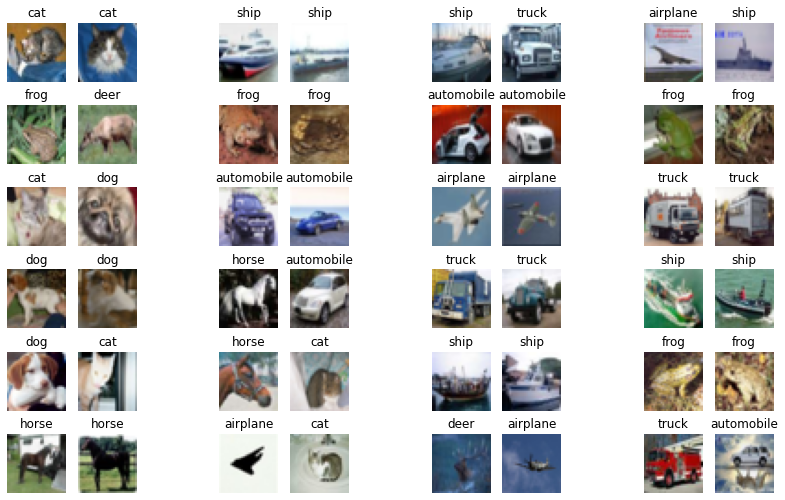

In [438]:
class_name = ["airplane","automobile","bird","cat","deer",
              "dog","frog","horse","ship","truck"]

plt.figure(figsize=[15,30])
for i in range(24):
    test_img = cv2.imread("images_test/image"+str(i+1)+".png")

    bins = (8,12,3)
    cd = ColorDescriptor(bins)
    HSV_features_test = np.array(cd.describe(test_img))
    
    pre_label = Best_clf.predict(HSV_features_test.reshape(1,len(HSV_features_test)))
    
    samples_index = np.where(train_labels == pre_label)[0]
    samples_distance_list=[]
    for j in samples_index:
        samples_MSE_distance = np.sum((HSV_Feature[j]-HSV_features_test)**2)
        samples_distance_list.append(samples_MSE_distance)

    samples_min_distance = samples_distance_list.index(min(samples_distance_list))
   
    plt.subplot(20,12,3*(i+1)-2)
    plt.axis("off")
    plt.title(class_name[test_labels[i]])
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    
    plt.subplot(20,12,3*(i+1)-1)
    plt.axis("off")
    plt.title(class_name[pre_label[0]])
    RetrievalImage = cv2.imread("images/img"+str(samples_index[samples_min_distance]+1)+".png")
    plt.imshow(cv2.cvtColor(RetrievalImage, cv2.COLOR_BGR2RGB))
    

It can be seen from the figure that the two pictures before and after have a strong similarity, and more than half of the images are correctly classified. This model is far more effective than the unsupervised learning model.

## 6. Comparison with Traditional Image Retrieval Methods
The image retrieval method used in this project is different from traditional methods. The traditional method omits the step of image classification, and directly calculates the distance from the query image feature to each image feature in the entire training set. In this section, I design an experiment to compare the performance of classification retrieval method with traditional method. I set two metrics, one is time consumption and the other is retrieval accuracy.

In [530]:
import time

### 6.1 Traditional Image Retrieval Methods

Elapsed time: 3.1563 seconds


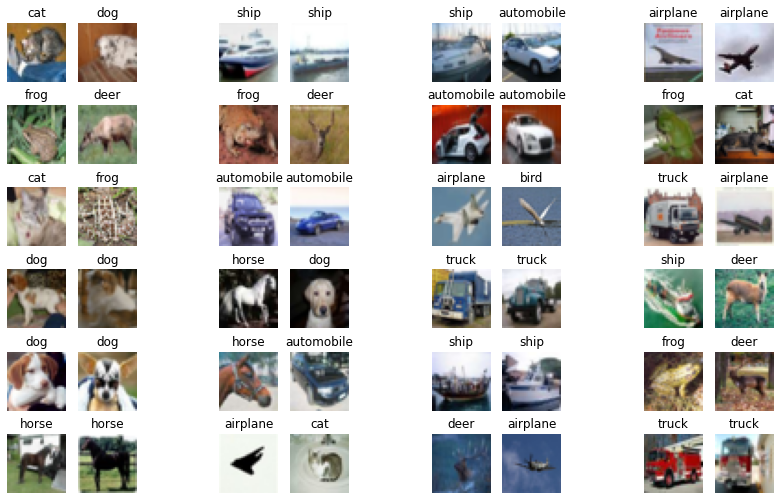

In [538]:
start_time = time.time()
class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.figure(figsize=[15,30])
for pic_num in range(24):
    test_img = cv2.imread("images_test/image"+str(pic_num+1)+".png")
    bins = (8,12,3)
    cd = ColorDescriptor(bins)
    HSV_features_test = np.array(cd.describe(test_img))
    distance = []
    for j in range(len(HSV_Feature)):
        samples_MSE_distance = np.sum((HSV_Feature[j]-HSV_features_test)**2)
        distance.append(samples_MSE_distance)
    min_distance = distance.index(min(distance))
    plt.subplot(20,12,3*(pic_num+1)-2)
    plt.axis("off")
    plt.title(class_name[test_labels[pic_num]])
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.subplot(20,12,3*(pic_num+1)-1)
    plt.axis("off")
    plt.title(class_name[train_labels[min_distance]])
    similar_image = cv2.imread("images/img"+str(min_distance+1)+".png")
    plt.imshow(cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB))  
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

### 6.2 Classification Image Retrieval Methods

Elapsed time: 1.6329 seconds


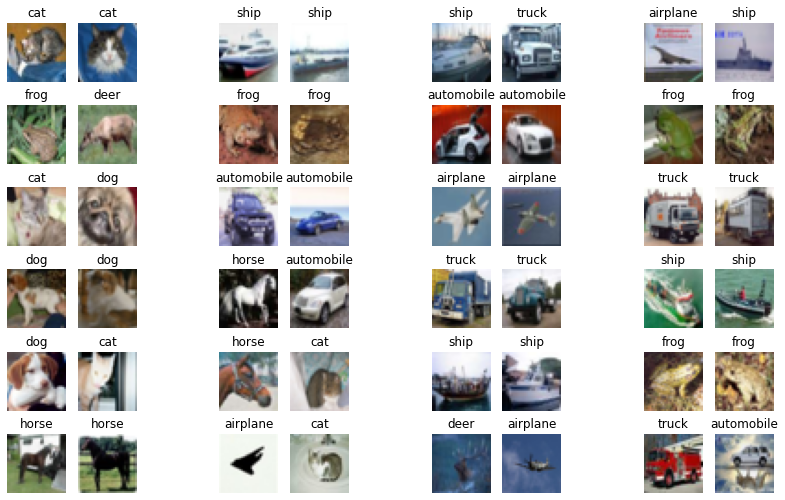

In [541]:
start_time = time.time()
class_name = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.figure(figsize=[15,30])
for pic_num in range(24):
    test_img = cv2.imread("images_test/image"+str(pic_num+1)+".png")
    bins = (8,12,3)
    cd = ColorDescriptor(bins)
    HSV_features_test = np.array(cd.describe(test_img))
    pre_label = Best_clf.predict(HSV_features_test.reshape(1,len(HSV_features_test)))
    samples_index = np.where(train_labels == pre_label)[0]
    samples_distance_list=[]
    for j in samples_index:
        samples_MSE_distance = np.sum((HSV_Feature[j]-HSV_features_test)**2)
        samples_distance_list.append(samples_MSE_distance)
    samples_min_distance = samples_distance_list.index(min(samples_distance_list))
    plt.subplot(20,12,3*(pic_num+1)-2)
    plt.axis("off")
    plt.title(class_name[test_labels[pic_num]])
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.subplot(20,12,3*(pic_num+1)-1)
    plt.axis("off")
    plt.title(class_name[pre_label[0]])
    RetrievalImage = cv2.imread("images/img"+str(samples_index[samples_min_distance]+1)+".png")
    plt.imshow(cv2.cvtColor(RetrievalImage, cv2.COLOR_BGR2RGB))    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

In terms of time consumption, the traditional method takes 3.1563 seconds, and the classification retrieval method takes 1.6329 seconds. In terms of retrieval accuracy, the accuracy of the traditional method is 41.67%, and the accuracy of the classification retrieval method is 58.33%. It can be seen that the image classification retrieval method used in this project is far superior to the traditional method.

## 7. Conclusion
Through sufficient experiments, this project has explored the best training features and models suitable for content-based image retrieval tasks, that is, the SVM model trained with HSV features. Furthermore, supervised learning methods are demonstrated to outperform unsupervised learning methods in content-based image retrieval tasks. Finally, the comparison experiment shows that the performance of the image classification retrieval method is far superior to the traditional image retrieval method.